In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wisps
import wisps.simulations as wispsim
import matplotlib as mpl
import astropy.units as u
from astropy.coordinates import SkyCoord
import theano
import theano.tensor as T
import pandas as pd
import pymc3 as pm
import seaborn as sns 
%matplotlib inline

In [2]:
COORDS=SkyCoord([p.coord for p in wisps.OBSERVED_POINTINGS ])

In [3]:
galc=COORDS.transform_to('galactic')

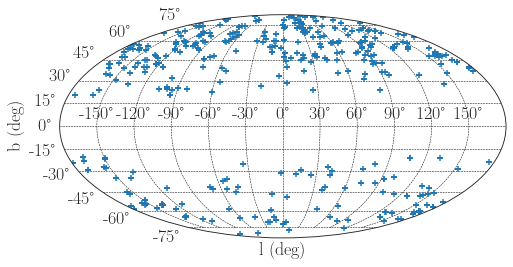

In [4]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(galc.l.wrap_at(180*u.degree).radian,galc.b.wrap_at(90*u.degree).radian, marker='+')
ax.set_xlabel('l (deg)', fontsize=18)
ax.set_ylabel('b (deg)', fontsize=18)
plt.grid()
plt.savefig(wisps.OUTPUT_FIGURES+'/fields_skymap.pdf')

In [5]:
LS=galc.l.radian

In [6]:
BS=galc.b.radian

In [7]:
Rsun=8300.
Zsun=27.

In [8]:
def density_function(r, z, h):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    
    zpart=(1./np.cosh(abs(z-Zsun)/(2*h)))**2
    rpart=np.exp(-(r-Rsun)/h)
    
    return zpart*rpart

In [22]:
dmaxses=[100, 500, 1000, 5000]
lbses=[(0, 0), (0,np.pi/2), (np.pi, 0), (np.pi, np.pi/2)]

In [24]:
def sample_distances( lbs, dmax, nsample=1000):
    """
    sample the galaxy given a scale height
    
    """
    def logp(r, z, d, h):
        return np.log10((d**2)*density_function(r, z, h))

    with pm.Model() as model:
        
        l=lbs[0]
        b=lbs[1]
        h=350.
        
        d=pm.Uniform('d', lower=0., upper=dmax, testval=dmax/2)
        
        r=pm.Deterministic('r', np.sqrt( (d * np.cos( b ) )**2 + Rsun * (Rsun - 2 * d * np.cos( b ) * np.cos( l ) ) ))
        z=pm.Deterministic('z', Zsun+ d * np.sin( b - np.arctan( Zsun / Rsun) ))
        
        like = pm.DensityDist('likelihood', logp, observed={
                             'r': r, 'z': z, 'd':d, 'h':h})

        trace = pm.sample(draws=int(nsample), cores=2, step=pm.Metropolis())
    return trace, model


In [25]:
import itertools

In [26]:
c = list(itertools.product(dmaxses, lbses))

In [27]:
c[0]

(100, (0, 0))

In [28]:
import corner

In [29]:
import astropy.units as u

In [30]:
from scipy.stats import gaussian_kde

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [d]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 5016.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [d]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 5598.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [d]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 4964.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [d]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 5428.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [d]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 5059.29draws/s]
The number of effective samples i

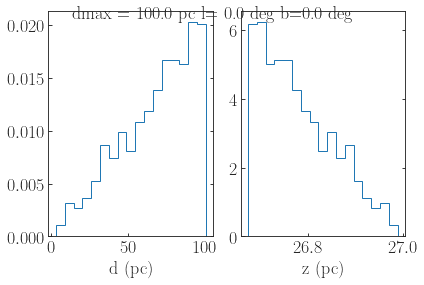

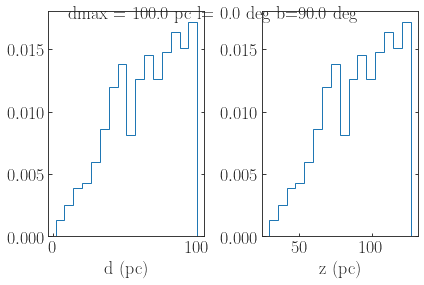

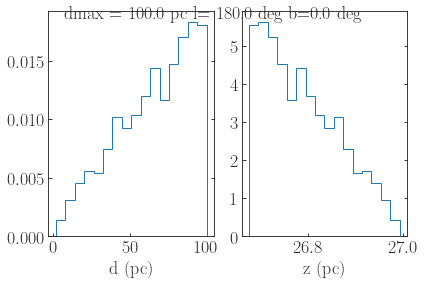

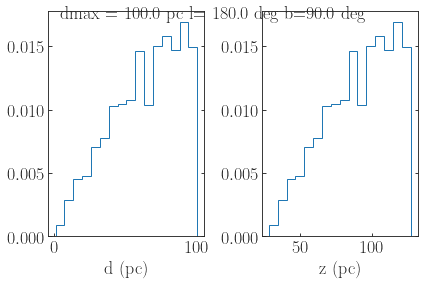

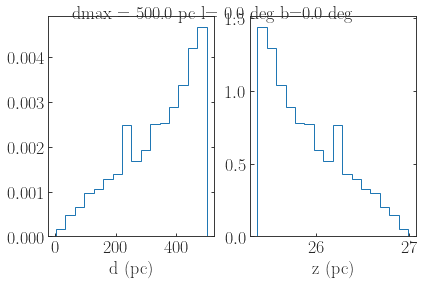

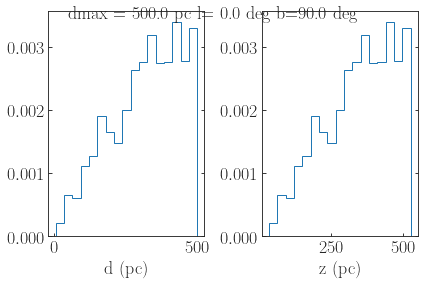

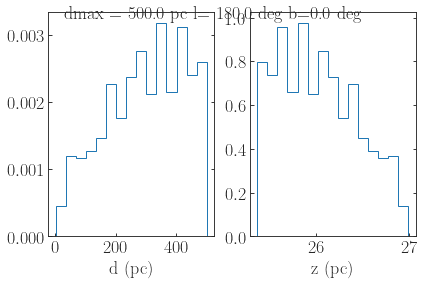

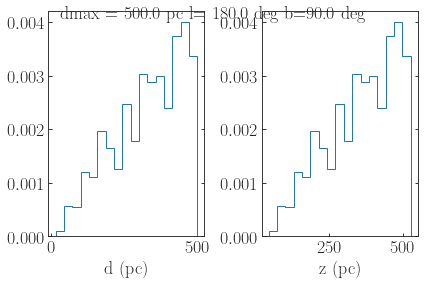

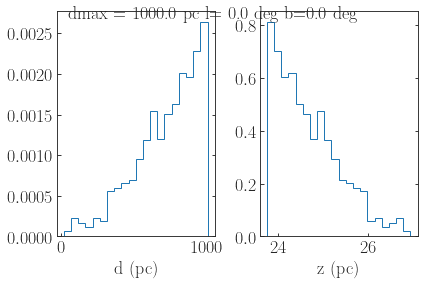

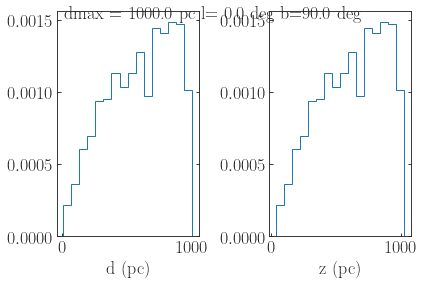

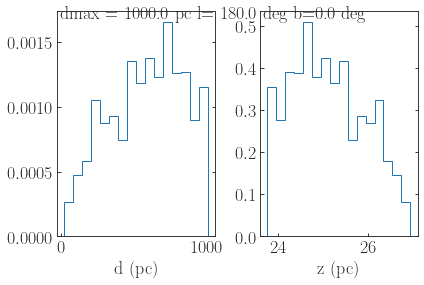

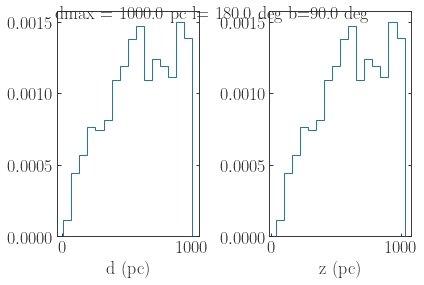

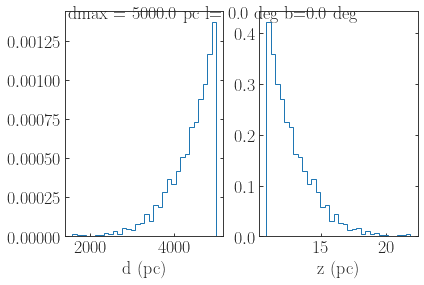

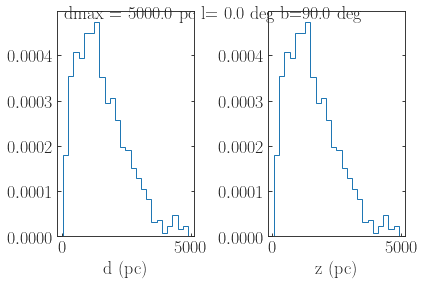

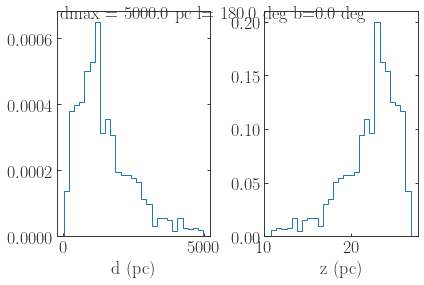

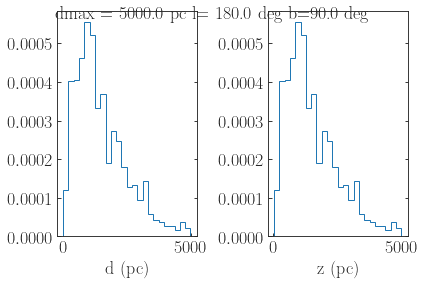

In [31]:

for comb in c:
    tr, model=sample_distances( comb[1], comb[0],nsample=1000)
    fig, ax=plt.subplots(ncols=2)
    h=ax[0].hist(tr.d, histtype='step', normed=True, bins='auto')
    h=ax[1].hist(tr.z, histtype='step', normed=True, bins='auto')
    ax[0].set_xlabel('d (pc)',fontsize=18)
    ax[1].set_xlabel('z (pc)',fontsize=18)
    plt.tight_layout()
    fig.suptitle("dmax = {} l= {} b={}".format(comb[0]*u.pc, (comb[1][0]*u.rad).to(u.deg),(comb[1][1]*u.rad).to(u.deg)), fontsize=18)
    plt.tight_layout()


In [32]:
#cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

In [33]:
stophere

NameError: name 'stophere' is not defined

In [ ]:
import wisps.simulations as wispsim

In [ ]:
dists=np.load(wisps.OUTPUT_FILES+'/bayesian_pointings.pkl', allow_pickle=True)

In [ ]:
rs=dists['rs']
zs=dists['zs']

In [ ]:
from matplotlib.colors import Normalize

In [ ]:
hs=[h for h in rs.keys()]

In [ ]:
cnorm=Normalize(hs[0], hs[-1])

In [ ]:
cmap = sns.cubehelix_palette(reverse=True, as_cmap=True)

In [ ]:
import matplotlib as mpl

In [ ]:
fig, ax=plt.subplots()

for k in hs:
    ax.scatter(rs[k], zs[k], color=cmap(cnorm(k)), alpha=0.01, s=1., marker='.' )
    
ax.set_xscale('log')

ax.set_xlabel('r (pc)', fontsize=18)
ax.set_ylabel('z (pc)', fontsize=18)

ax2=fig.add_axes([0.1, -0.2, 0.81, 0.1])



cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=cnorm,
                            orientation='horizontal')

plt.tight_layout()

cb1.set_label('h (pc)', fontsize=18)

plt.savefig(wisps.OUTPUT_FIGURES+'/galactic_distribution_sim.jpeg', bbox_inches='tight')